In [3]:
import glob
import os
import json
import random

import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import copy
import cPickle as pkl

from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.classifications import linearSVC_class as lsvc

In [4]:
import pylab as pl
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter


In [5]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, permutation_test_score, cross_val_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


In [6]:
%matplotlib notebook

In [7]:
def load_roi_list(animalid, session, fov, run, traceid, roistats_dir='response_stats', roi_selector='visual'):

    traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % self.fov, run,\
                                         'traces', '%s*' % traceid))[0]

    if roi_selector == 'all':
        roi_list = None
    else:
        roistats_results_fpaths = os.path.join(traceid_dir, '%s*' % response_stats, 'roistats_results.npz')
        if len(roistats_results_fpaths) > 1:
            for fi, fpath in enumerate(sorted(roistats_results_fpaths)):
                print fi, fpath
            sel = input("Select IDX of roistats to use: ")
            roistats_results_fpath = roistats_results_fpaths[sel]
        else:
            roistats_results_fpath = roistats_results_fpaths[0]
        roistats = np.load(roistats_results_fpath)

        roi_subset_type = 'sorted_%s' % roi_selector
        roi_list = roistats[roi_subset_type]

    return roi_list


In [8]:
class struct():
    pass

class DataSet():
    
    def __init__(self, animalid='RATID', session='YYYYMMDD', fov='FOV1_zoom1p0x', run='experiment_run1', 
                 traceid='traces00x', rootdir='/n/coxfs01/2p-data'):
        self.rootdir=rootdir
        self.animalid = animalid
        self.session = session
        self.fov = fov
        self.run = run
        self.traceid = traceid
        datafiles = glob.glob(os.path.join(rootdir, animalid, session, \
                                           '%s*' % fov, run, 'traces', '%s*' % traceid, \
                                           'data_arrays', 'datasets*.npz'))
        if len(datafiles) > 1:
            for fi, df in enumerate(sorted(datafiles)):
                print(fi, df)
            sel = int(input('Sel IDX of traceid to use: '))
            dpath = sorted(datafiles)[sel]
        else:
            dpath = datafiles[0]
        self.source = dpath
        
        self.data_identifier = '_'.join((animalid, session, fov, run, traceid))

        self.datasets = {}
    

    def load_dataset(self, roi_selector='visual', visual_area='visual_area_name', \
                     segmented_areas_fpath=None, roistats_dir='sorted_rois', aspect=1.0):
        
        print("------------ Loading dataset.")
        # Store DATASET:            
        dt = np.load(self.source)
        if 'arr_0' in dt.keys():
            dataset = dt['arr_0'][()]
        else:
            dataset = dt           

        # Store run info:
        if isinstance(dataset['run_info'], dict):
            run_info = dataset['run_info']
        else:
            run_info = dataset['run_info'][()]
        
        # Store stim configs:
        if isinstance(dataset['sconfigs'], dict):
            orig_sconfigs = dataset['sconfigs']
        else:
            orig_sconfigs = dataset['sconfigs'][()]

        # Make sure numbers are rounded:
        for cname, cdict in orig_sconfigs.items():
            for stimkey, stimval in cdict.items():
                if isinstance(stimval, (int, float)):
                    orig_sconfigs[cname][stimkey] = round(stimval, 1)
                    
        # Add combined 'position' variable to stim configs:
        for cname, config in orig_sconfigs.items():
            pos = '_'.join([str(config['xpos']), str(config['ypos'])])
            orig_sconfigs[cname].update({'position': pos})
        
        # Correct for old naming scheme for morph levels:
        if int(self.session) < 20180602:
            # Rename morphs:
            update_configs = [cfg for cfg, info in orig_sconfigs.items() if info['morphlevel'] > 0]
            for cfg in update_configs:
                if orig_sconfigs[cfg]['morphlevel'] == 6:
                    orig_sconfigs[cfg]['morphlevel'] = 27
                elif orig_sconfigs[cfg]['morphlevel'] == 11:
                    orig_sconfigs[cfg]['morphlevel'] = 53
                elif orig_sconfigs[cfg]['morphlevel'] == 16:
                    orig_sconfigs[cfg]['morphlevel'] = 79
                elif orig_sconfigs[cfg]['morphlevel'] == 22:
                    orig_sconfigs[cfg]['morphlevel'] = 106
                else:
                    print("Unknown morphlevel converstion: %i" % orig_sconfigs[cfg]['morphlevel'])
        
        for cfg in orig_sconfigs.keys():
            orig_sconfigs[cfg]['size'] = round(orig_sconfigs[cfg]['size']/aspect, 1)
        
        # Make sure specified const_trans are actually tested transforms:
        sdf = pd.DataFrame(orig_sconfigs).T
#         id_preserving_transforms = ['xpos', 'ypos', 'size', 'yrot']
#         true_trans_dict = dict((tkey, list(set(sdf[tkey]))) for tkey in id_preserving_transforms)
#         varying_transforms = [t for t,vals in true_trans_dict.items() if len(vals) > 1]
    
        visual_areas_fpath=''; included_rois=None; areas=None;
        if segmented_areas_fpath is not None:
            print("Getting ROIs for area: %s" % visual_area)
            print("Loading file:", segmented_areas_fpath)
            with open(segmented_areas_fpath, 'rb') as f:
                areas = pkl.load(f)
            if visual_area not in areas.regions.keys():
                print("Specified visual area - %s - NOT FOUND.")
                for vi, va in enumerate(areas.regions.keys()):
                    print(vi, va)
                sel = input("Select IDX of area to use: ")
                visual_area = areas.regions.keys()[sel]
            included_rois = [int(ri) for ri in areas.regions[visual_area]['included_rois']]
        else:
            included_rois = None
        
        brain_region = {}
        brain_region['name'] = visual_area
        brain_region['source'] = segmented_areas_fpath
        brain_region['roi_indices'] = included_rois
        brain_region['segmentation'] = None if areas is None else areas.regions[visual_area]  
        
        self.update_data(dataset, sdf, run_info, brain_region, roistats_dir=roistats_dir, roi_selector=roi_selector)

    def load_roi_list(self, roistats_dir='sorted_rois', roi_selector='visual'):
        
        traceid_dir = glob.glob(os.path.join(self.rootdir, self.animalid, self.session, '%s*' % self.fov, run, 'traces', '%s*' % self.traceid))[0]
        
#         if roi_selector == 'all':
#             roi_list = None
#         else:
#             roistats_results_fpath = os.path.join(traceid_dir, 'sorted_rois', 'roistats_results.npz')
#             roistats = np.load(roistats_results_fpath)

#             roi_subset_type = 'sorted_%s' % roi_selector
#             roi_list = roistats[roi_subset_type]

        if roi_selector == 'all':
            roi_list = None
        else:
            roistats_results_fpaths = glob.glob(os.path.join(traceid_dir, '%s*' % roistats_dir, 'roistats_results.npz'))
            if len(roistats_results_fpaths) > 1:
                for fi, fpath in enumerate(sorted(roistats_results_fpaths)):
                    print fi, fpath
                sel = input("Select IDX of roistats to use: ")
                roistats_results_fpath = roistats_results_fpaths[sel]
            else:
                roistats_results_fpath = roistats_results_fpaths[0]
            roistats = np.load(roistats_results_fpath)

            roi_subset_type = 'sorted_%s' % roi_selector
            roi_list = roistats[roi_subset_type]
        

        return roi_list

    def update_data(self, dataset, sdf, run_info, brain_region, roistats_dir='sorted_rois', roi_selector='visual'):
        d = struct()
        
        # Get visual rois:
        visual_rois = self.load_roi_list(roistats_dir=roistats_dir, roi_selector=roi_selector)
        if visual_rois is None:
            visual_rois = np.arange(0, dataset['corrected'].shape[1])
    
        # Get subset of rois within specified visual area:
        rois_in_visual_area=None
        if brain_region['roi_indices'] is not None:
            rois_in_visual_area = np.array(brain_region['roi_indices'])
        
        # Get final roi indices:
        if rois_in_visual_area is not None:
            roi_indices = intersection(visual_rois, rois_in_visual_area)
        else:
            roi_indices = visual_rois.copy()
    
        # Get subset of roi traces specified:
        traces = dataset['corrected'][:, roi_indices]
        
        # Get labels dataframe (for traces):
        labels = pd.DataFrame(data=dataset['labels_data'], columns=dataset['labels_columns'])
        
        d.traces = traces
        d.labels = labels
        d.roi_indices = roi_indices
        d.conditions = sdf
        d.run_info = run_info
        d.brain_region = brain_region
        
        self.datasets.update({'%s' % brain_region['name']: d})
        

In [9]:
def get_formatted_data(xdata, labels, multiple_durs=True, data_type='stat', stat_type='meanstim', get_null=False): #get_training_data(self):
    '''
    Returns input data formatted as:
        ntrials x nrois (data_type=='stat')
        nframes x nrois (data_type = 'frames')
    Filters nrois by roi_selector.
    '''
    print("------------ Formatting data into samples.")


    # Determine whether all trials have the same structure or not:
    multiple_durs = len(list(set(labels['nframes_on']))) > 1

    if data_type == 'stat':
        cX, cy = get_stat_samples(xdata, labels, multiple_durs=multiple_durs, stat_type=stat_type, get_null=get_null)
    else:
        cX, cy = get_frame_samples(xdata, labels, self.params)

    print("Ungrouped dataset cX:", cX.shape)
    print("Ungrouped dataset labels cy:", cy.shape)

    return cX, cy

In [10]:

def get_stat_samples(traces, labels, multiple_durs=True, stat_type='meanstim', get_null=False):
    ntrials_total = len(labels['trial'].unique())
    ntrials_per_cond = [len(t) for t in labels.groupby('config')['trial'].unique()]
    if len(np.unique(ntrials_per_cond)) > 1:
        print("***warning*** uneven reps per condition: %s" % str(np.unique(ntrials_per_cond)))
    #assert len(np.unique(ntrials_per_cond)) == 1, "Uneven reps per condition! %s" % str(ntrials_per_cond)
    ntrials = np.unique(ntrials_per_cond)[0]
    
    # Get baseline and stimulus indices for each trial:
    sample_labels = []
    stim_on_frame = labels['stim_on_frame'].unique()
    assert len(stim_on_frame) == 1, "More than 1 stim on frame found! %s" % str(stim_on_frame)
    stim_on_frame = stim_on_frame[0]
    if multiple_durs:
        tgroups = labels.groupby('trial')            
        std_baseline_values=[]; mean_baseline_values=[]; mean_stimulus_values=[];
        for k,g in tgroups:
            curr_nframes_on = g['nframes_on'].unique()[0]

            curr_baseline_stds = np.nanstd(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)
            curr_baseline_means = np.nanmean(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)

            curr_stimulus_means = np.nanmean(traces[g['tsec'][stim_on_frame:stim_on_frame+curr_nframes_on].index.tolist(), :], axis=0)
            
            std_baseline_values.append(curr_baseline_stds)
            mean_baseline_values.append(curr_baseline_means)
            mean_stimulus_values.append(curr_stimulus_means)
            
            curr_config = g['config'].unique()[0]
            sample_labels.append(curr_config)
        
        mean_stim_on_values = np.vstack(mean_stimulus_values)
        mean_baseline_values = np.vstack(mean_baseline_values)
        std_baseline_values = np.vstack(std_baseline_values)
        
    else:
        nrois = traces.shape[-1]
        nframes_per_trial = traces.shape[0] / ntrials_total
        assert len(labels['nframes_on'].unique()) == 1, "Uneven num frames stim ON: %s" % str(labels['nframes_on'].unique())
        nframes_on = labels['nframes_on'].unique()[0]
        
        tracemat = np.reshape(traces, (ntrials_total, nframes_per_trial, nrois), order='C')
        sample_labels = np.reshape(labels['config'].tolist(), (ntrials_total, nframes_per_trial), order='C')[:, 0]
        
        std_baseline_values = np.nanstd(tracemat[:, 0:stim_on_frame], axis=1)
        mean_baseline_values = np.nanmean(tracemat[:, 0:stim_on_frame], axis=1)
        mean_stim_on_values = np.nanmean(tracemat[:, stim_on_frame:stim_on_frame+nframes_on], axis=1)
            
    if stat_type == 'zscore':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / std_baseline_values
    elif stat_type == 'meanstimdff':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / mean_baseline_values
    else:
        sample_array = mean_stim_on_values.copy()
    
    if get_null:
        random_draw = True
        print("Stim values:", sample_array.shape)
        if random_draw:
            selected_trial_ixs = random.sample(range(0, mean_baseline_values.shape[0]), ntrials)
        bas = mean_baseline_values[selected_trial_ixs, :]
    
        sample_array = np.append(sample_array, bas, axis=0)
        print("Added null cases:", sample_array.shape)
        sample_labels.extend(['bas' for _ in range(bas.shape[0])])
    
    return sample_array, np.array(sample_labels)

In [45]:
def get_best_C(svc_in, cX, cy, output_dir=None, figname=None, close=True):
    # Look at cross-validation scores as a function of parameter C
    svc = copy.copy(svc_in)
    C_s = np.logspace(-10, 10, 50)
    scores = list()
    scores_std = list()
    for C in C_s:
        svc.C = C
        this_scores = cross_val_score(svc, cX, cy, n_jobs=1)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))

    # Do the plotting
    pl.figure(figsize=(4,4))
    pl.semilogx(C_s, scores)
    pl.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
    pl.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
    locs, labels = pl.yticks()
    pl.yticks(locs, list(map(lambda x: "%g" % x, locs)))
    pl.ylabel('CV score')
    pl.xlabel('Parameter C')
    pl.ylim(0, 1.1)

    best_idx_C = scores.index(np.max(scores))
    best_C = C_s[best_idx_C]
    pl.title('best C: %0.4f' % best_C)

    if output_dir is not None:
        if figname is None:
            figname = 'crossval_score_by_C'
        pl.savefig(os.path.join(output_dir, '%s.png' % figname))
        if close:
            pl.close()

    return best_C



In [12]:

def plot_confusion_matrix(cmatrix, classes,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix', clim=None,
                          cmap=pl.cm.Blues, cmin=0, cmax=1.0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        if clim=='max':
            cmax = cmatrix.max()
    else:
        print('Confusion matrix, without normalization')

    if ax is None:
        fig = pl.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

    ax.set_title(title, fontsize=10)

    im = ax.imshow(cmatrix, interpolation='nearest', cmap=cmap, vmax=cmax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=8)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=8)
    fmt = '.1f' if normalize else 'd'
    thresh = cmatrix.max() #/ 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        ax.text(j, i, format(cmatrix[i, j], fmt),
                 horizontalalignment="center", fontsize=6,
                 color="white" if cmatrix[i, j] > thresh else "black")

    #pl.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im, cax=cax)

    return ax

In [13]:
def group_by_class(cX, cy, conditions, class_name='CLASS'):
    cy_tmp = cy.copy()
    cy = np.array([conditions.loc[cv][class_name] if cv != 'bas' else 'bas' for cv in cy_tmp])

    cy = np.array([round(c, 1) for c in cy])
    class_labels = sorted(list(set(cy))) 
    return cX, cy, class_labels

In [14]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 


# Create DataSet object:

#### Set data source

In [5289]:
# size/morphs:  V1
# -------------------------------------------
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC059'
# session = '20190227'
# fov = 'FOV4_zoom4p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'V1'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC059'
# session = '20190228'
# fov = 'FOV1_zoom4p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'V1'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC047'
# session = '20190216'
# fov = 'FOV1_zoom4p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001'
# segment_visual_area = False
# visual_area = 'V1'

# size/morphs:  LI/LL
# -------------------------------------------
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC067'
session = '20190319' # 
fov = 'FOV1_zoom2p0x'
run = 'combined_blobs_static'
traceid = 'traces002' #
segment_visual_area = False
visual_area = 'LILL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC067'
# session = '20190320' # '20190319'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #'traces002'
# segment_visual_area = False
# visual_area = 'LILL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC073'
# session = '20190322' # '20190319'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #'traces002'
# segment_visual_area = True
# visual_area = 'LI'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC070'
# session = '20190314' # 
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces002' #
# segment_visual_area = False
# visual_area = 'LILL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC070'
# session = '20190315' # 
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #
# segment_visual_area = False
# visual_area = 'LILL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC070'
# session = '20190316' # 
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #
# segment_visual_area = False
# visual_area = 'LILL'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC070'
# session = '20190321' # 
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #
# segment_visual_area = False
# visual_area = 'LILL'

# size/morphs:  LM
# # -------------------------------------------
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC073'
# session = '20190322' # '20190319'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_blobs_static'
# traceid = 'traces001' #'traces002'
# segment_visual_area = True
# visual_area = 'LM'



In [5290]:
D = DataSet(animalid=animalid, session=session, fov=fov, run=run, traceid=traceid)
print(D.source)

/n/coxfs01/2p-data/JC067/20190319/FOV1_zoom2p0x/combined_blobs_static/traces/traces002_f60652_traces002_79b398_traces002_669b8c_traces002_347858_traces002_3a9b9e_traces002_a64bf7/data_arrays/datasets.npz


In [5291]:
if segment_visual_area:
    segmented_files = sorted(glob.glob(os.path.join(D.rootdir, D.animalid, D.session, D.fov, 'visual_areas', 'segmentation_*.pkl')), key=natural_keys)[::-1]
    segmented_areas_fpath = segmented_files[0]
else:
    segmented_areas_fpath = None
print(segmented_areas_fpath)

None


#### Load data

In [5292]:

D.load_dataset(roi_selector='visual', visual_area=visual_area, aspect=1.747,
               segmented_areas_fpath=segmented_areas_fpath, roistats_dir='response_stats')
print(D.datasets)
print("%s: \n" % visual_area, dir(D.datasets[visual_area]))

------------ Loading dataset.
{'LILL': <__main__.struct instance at 0x7fcc5c7ac170>}
LILL: 
 ['__doc__', '__module__', 'brain_region', 'conditions', 'labels', 'roi_indices', 'run_info', 'traces']


In [5293]:
if segment_visual_area:
    print(D.datasets[visual_area].roi_indices)
    print(len(D.datasets[visual_area].roi_indices))

In [5294]:
d = D.datasets[visual_area]
print("--- raw traces:", d.traces.shape)
print("--- corresp. labels:", d.labels.shape)
print("--- conditions dataframe:\n", d.conditions.head())

--- raw traces: (298350, 248)
--- corresp. labels: (298350, 6)
--- conditions dataframe:
           morphlevel   object position size stimtype xpos ypos yrot
config001          0  Blob_N1  0.0_0.0   10    image    0    0    0
config002          0  Blob_N1  0.0_0.0   20    image    0    0    0
config003          0  Blob_N1  0.0_0.0   30    image    0    0    0
config004          0  Blob_N1  0.0_0.0   40    image    0    0    0
config005          0  Blob_N1  0.0_0.0   50    image    0    0    0


In [5295]:

print("xpos:", list(set(d.conditions['xpos'])))
print("ypos:", list(set(d.conditions['ypos'])))
print("size:", list(set(d.conditions['size'])))
if 'morphlevel' in d.conditions.columns.tolist():
    print("morphlevel:", list(set(d.conditions['morphlevel'])))
print(d.run_info['trans_types'])

xpos: [0.0]
ypos: [0.0]
size: [40.0, 10.0, 20.0, 50.0, 30.0]
morphlevel: [0.0, 66.0, 40.0, 106.0, 14.0, 79.0, 53.0, 27.0, 92.0]
['morphlevel', 'size']


In [5296]:
sample_data, sample_labels = get_formatted_data(d.traces, d.labels)
print(sample_data.shape)
print(sample_labels.shape)
        

------------ Formatting data into samples.
('Ungrouped dataset cX:', (1350, 248))
('Ungrouped dataset labels cy:', (1350,))
(1350, 248)
(1350,)


In [5297]:
D.session

'20190319'

In [5298]:
# # -------------------------------------------------------------------------
# # MODEL SELECTION PARAMS:
# feature_select_method='rfe' #'rfe' #'rfe'
# feature_select_n='best' #'best' #'best'
# C_select='big' #'best'
# # -------------------------------------------------------------------------

# # -------------------------------------------------------------------------
# # TRAINING PARAMS:
# scoring = 'accuracy'
# full_train = False
# test_size = 0.2 #0.33 #0.33 #0.20 #0.33 #0.33
# create_new = True

# m50 = 53
# m100 = 106 #106

# col_label = 'xpos' # 'xpos'
# row_label = 'ypos' #'ypos'

# Select train and test sets

In [5299]:
print("Transforms tested:", d.run_info['trans_types'])
transforms = {}
for trans in d.run_info['trans_types']:
    transforms[trans] = list(set(d.conditions[trans]))
transforms

Transforms tested: ['morphlevel', 'size']


{'morphlevel': [0.0, 66.0, 40.0, 106.0, 14.0, 79.0, 53.0, 27.0, 92.0],
 'size': [40.0, 10.0, 20.0, 50.0, 30.0]}

aspect_ratio = 1.747 #[t/1.747 for t in train_labels]
[17.000572409845446,
 23.983972524327417,
 31.02461362335432,
 38.008013737836293,
 44.991413852318253]

In [5300]:
find_best_stimulus = False

# which is the best position?
if find_best_stimulus:

    class_name='size'
    cX, cy, train_labels = group_by_class(sample_data, sample_labels, d.conditions, class_name=class_name)
    cX = StandardScaler().fit_transform(cX)

    print("Train data:", cX.shape)
    print("Train labels:", train_labels)

    dual = cX.shape[0] > cX.shape[1]
    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1e9) #, C=self.clfparams['C_val'])

    best_C = get_best_C(svc, cX, cy)

    C = best_C

    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])
    
    
    
    cv_nfolds = 5
    scoring = 'accuracy'
    rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
    fit = rfe.fit(cX, cy)

    best_score = fit.grid_scores_[fit.n_features_ - 1]
    kept_rids = fit.get_support(indices=True)
    nfeatures_best = len(kept_rids) #fit.n_features_
    print("N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape)
    all_scores = fit.grid_scores_

    fig = pl.figure(figsize=(4,4))
    pl.plot(range(1, len(all_scores) + 1), all_scores)
    pl.xlabel("N features selected")
    pl.ylabel(scoring)
    pl.title("optimal: %i" % len(kept_rids))

    fit_best = True

    if fit_best:
        roi_indices = kept_rids.copy()
    else:
        roi_indices = np.arange(0, cX.shape[1])


    xdata = cX[:, kept_rids]
    xlabels = cy

    dual = xdata.shape[0] > xdata.shape[1]
    svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=best_C) #, C=self.clfparams['C_val'])


In [5301]:
transforms

{'morphlevel': [0.0, 66.0, 40.0, 106.0, 14.0, 79.0, 53.0, 27.0, 92.0],
 'size': [40.0, 10.0, 20.0, 50.0, 30.0]}

# Choose classes to train

##### Create output dirs

In [5302]:
        
#classifier_regime = 'decode_ori_train_test_size'
#classifier_regime = 'decode_AB_train_anchors_test_morphs'
classifier_regime = 'decode_AB_train_test_size_subsets'

In [5303]:
fov_list = [D.fov]
session_list = [D.session]
traceid_list = [D.traceid]

for vi, (fv, sv, tv) in enumerate(zip(fov_list, session_list, traceid_list)):
    fov_list[vi] = '_'.join([sv, fv.split('_zoom')[0], tv])
print(fov_list)
fov_dirname = '_'.join(fov_list)
if segment_visual_area:
    fov_dirname = '%s_segmented%s' % (fov_dirname, visual_area)

session_list = [D.session]


if '/' in visual_area: 
    visual_area = visual_area.replace('/', '_')

output_dir = os.path.join(D.rootdir, D.animalid, visual_area, fov_dirname, 'classifiers', classifier_regime)
if not os.path.exists(output_dir): os.makedirs(output_dir)
print("Saving output figures:\n%s" % output_dir)

['20190319_FOV1_traces002']
Saving output figures:
/n/coxfs01/2p-data/JC067/LILL/20190319_FOV1_traces002/classifiers/decode_AB_train_test_size_subsets


# Set training stimulus set

In [5304]:
transforms

{'morphlevel': [0.0, 66.0, 40.0, 106.0, 14.0, 79.0, 53.0, 27.0, 92.0],
 'size': [40.0, 10.0, 20.0, 50.0, 30.0]}

In [5368]:
# Get list of configs with specified params:
class_name = 'morphlevel'

test_morphs = False # True if morph curve; False if test generalization

train_anchors_only = True
test_anchors_only = True

# Choose training subset
transform_spanned = 'size' #'size' #'size' #'position' #'size' #'position'
train_transforms = [20, 40] #[40, 50] #[30, 40] 

# Set these to pin training to a specific transform set
xpos = []
ypos = []
yrot = []
size = []
positions = list(set(d.conditions['position']))

if transform_spanned is None:
    test_transforms = []
    train_transforms = []
    train_transform_subset = False
else:
    all_transform_values = list(set(d.conditions[transform_spanned]))
    #train_transforms = [10, 20, 30, 40] #[20, 30] #[20, 25] #['0.0_5.0', '14.0_5.0'] #[7, 27] 
    test_transforms = [p for p in all_transform_values if p not in train_transforms] # [17, 37] #[p for p in positions if p not in test_transforms]
    train_transform_subset = True
    
print("Train transforms:", train_transforms)
print("Test transforms:", test_transforms)


# -------------------------------------------------------------------------

all_classes = sorted(list(set(d.conditions[class_name]))) #[0, 106]

if train_anchors_only and test_anchors_only:
    train_classes = [all_classes[0], all_classes[-1]]
    test_classes = [all_classes[0], all_classes[-1]]
elif train_anchors_only and not test_anchors_only:
    train_classes = [all_classes[0], all_classes[-1]]
    test_classes = [i for i in list(set(d.conditions[class_name])) if i not in train_classes]
else:
    train_classes = copy.copy(all_classes)
    test_classes = copy.copy(train_classes) #[0, 106]
    
print("train classes:", train_classes)
print("test classes:", test_classes)
# -------------------------------------------------------------------------


Train transforms: [20, 40]
Test transforms: [10.0, 50.0, 30.0]
train classes: [0.0, 106.0]
test classes: [0.0, 106.0]


#### Get corresponding "config" names

In [5369]:

if len(yrot) > 0: #'yrot' in d.conditions.columns.tolist():
    sdf = d.conditions[(d.conditions['yrot'].isin(yrot))]
else:
    sdf = d.conditions.copy()

if len(xpos) > 0:
    sdf = sdf[(sdf['xpos'].isin(xpos))]
if len(ypos) > 0:
    sdf = sdf[(sdf['ypos'].isin(ypos))]

if len(size) > 0:
    sdf = sdf[(sdf['size'].isin(size))]

#
# 
if train_transform_subset:
    train_sdf = sdf[sdf[transform_spanned].isin(train_transforms)]
    test_sdf = sdf[sdf[transform_spanned].isin(test_transforms)]
else:
    train_sdf = sdf.copy()
    test_sdf = sdf.copy()
    

train_configs = train_sdf[train_sdf[class_name].isin(train_classes)].index.tolist()
test_configs = test_sdf[test_sdf[class_name].isin(test_classes)].index.tolist()

print("-- train configs:", train_configs)
print("-- test configs:", test_configs)

#print(sdf)

-- train configs: ['config002', 'config004', 'config042', 'config044']
-- test configs: ['config001', 'config003', 'config005', 'config041', 'config043', 'config045']


In [5370]:
train_sdf.head()

,morphlevel,object,position,size,stimtype,xpos,ypos,yrot
config002,0,Blob_N1,0.0_0.0,20,image,0,0,0
config004,0,Blob_N1,0.0_0.0,40,image,0,0,0
config007,14,morph14,0.0_0.0,20,image,0,0,0
config009,14,morph14,0.0_0.0,40,image,0,0,0
config012,27,morph27,0.0_0.0,20,image,0,0,0


### Get trials for train and test sets

In [5430]:
split_train_test = True #True
perc_test = 0.3 # 0.3

print(sample_data.shape)
trial_groups = d.labels.groupby('trial') #shape
trial_mapping = {}
for tcounter, (t,g) in enumerate(trial_groups):
    trial_mapping[t] = tcounter


test_indices =  [int(trial_mapping[trial]) for trial, trialdf in trial_groups \
                 if trialdf['config'].isin(test_configs).all()]
train_indices = []
if split_train_test:
    for train_config in train_configs:
        all_train_indices = np.array([int(trial_mapping[trial]) for trial, trialdf in trial_groups \
                             if trialdf['config'].isin([train_config]).all()])
                             
        # Randomly choose N train/test trials
        n_test_samples = int(len(all_train_indices) * perc_test)
        n_train_samples = len(all_train_indices) - n_test_samples
        indices_held_for_train = np.array(random.sample(np.arange(0, len(all_train_indices)), n_train_samples))
        indices_held_for_test = np.array([t for t in np.arange(0, len(all_train_indices)) \
                                          if t not in indices_held_for_train])
        
        train_indices.extend(all_train_indices[indices_held_for_train])
        test_indices.extend(all_train_indices[indices_held_for_test])
else:
    train_indices = [int(trial_mapping[trial]) for trial, trialdf in trial_groups \
                     if trialdf['config'].isin(train_configs).all()]

nsame_cfgs = sum([1 if tr==ts else 0 for tr, ts in zip(train_indices, test_indices)])
assert nsame_cfgs==0, "**Train and Trial indices overlap!"
# if len(trial_mapping.keys()) < int(t[5:]):
    # print("Trials are not sequentially labeled (skipped trials)")
# train_indices = [int(trial_mapping[trial]) for trial, trialdf in trial_groups \
#                  if trialdf['config'].isin(train_configs).all()]
# test_indices =  [int(trial_mapping[trial]) for trial, trialdf in trial_groups \
#                  if trialdf['config'].isin(test_configs).all()]
# else:
#     train_indices2= [int(trial[5:])-1 for trial, trialdf in trial_groups \
#                      if trialdf['config'].isin(train_configs).all()]
#     test_indices2=  [int(trial[5:])-1 for trial, trialdf in trial_groups \
#                      if trialdf['config'].isin(test_configs).all()]


# nsame_cfgs = sum([1 if tr==ts else 0 for tr, ts in zip(train_indices, test_indices)])
# if nsame_cfgs == len(train_indices):
#     print("@@Same test and train trials!!@@")

    
# perc_test = 0.20
# if split_train_test:
#     n_test_samples = int(len(train_indices) * perc_test)
#     test_indices = random.sample(range(0, len(train_indices)), n_test_samples)


print("Total %i training trials." % (len(train_indices)))
print("Total %i testing trials." % (len(test_indices)))
    

(1350, 248)
Total 84 training trials.
Total 216 testing trials.


In [5431]:
data_in = StandardScaler().fit_transform(sample_data)
print("All trials:", sample_data.shape)
traindata = data_in[train_indices, :]
trainlabels = sample_labels[train_indices]

testdata = data_in[test_indices,:]
testlabels = sample_labels[test_indices]

print("train data:", traindata.shape)
print("test data:", testdata.shape)

All trials: (1350, 248)
train data: (84, 248)
test data: (216, 248)


In [5432]:
print(len(list(set(trainlabels))))
counts_by_train_config = Counter(trainlabels)
for cfg, n in counts_by_train_config.items():
    print(cfg, n)

4
config042 21
config004 21
config002 21
config044 21


#### Create TRAIN and TEST sets:

In [5433]:
print("CLASS: %s" % class_name)

cX, cy, train_labels = group_by_class(traindata, trainlabels, d.conditions, class_name=class_name)
print("Train data:", cX.shape)
print("Train labels:", train_labels)


test_cx, test_cy, test_labels = group_by_class(testdata, testlabels, d.conditions, class_name=class_name)
print("Test data:", test_cx.shape)
print("Train labels:", test_labels)



CLASS: morphlevel
Train data: (84, 248)
Train labels: [0.0, 106.0]
Test data: (216, 248)
Train labels: [0.0, 106.0]


In [5434]:
cv_nfolds = 5
scoring = 'accuracy'

# Set figure suffix for descriptive fname

In [5435]:
if split_train_test:
    split_train_str = '_trainAB_split%.2ftrials' % perc_test
else:
    split_train_str = '_trainAB_split0trials'
    
train_test_cfg_str = '%s' % split_train_str
if train_transform_subset:
    train_test_cfg_str = '%s_across_%s_%s' % (split_train_str, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
print("Train/test subset of a transform? %s" % train_test_cfg_str)

train_subset_cfg_str = ''
if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
    train_subset_cfg_str = '_configsubset_x%s_y%s_sz%s' % ('_'.join([str(int(x)) for x in xpos]), \
                                  '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))
print("Train config subsets? %s" % train_subset_cfg_str)

Train/test subset of a transform? _trainAB_split0.30trials_across_size_20_40
Train config subsets? 


# Model selection

In [5436]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)

# Loading the Digits dataset


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = cX.shape[0]
X = StandardScaler().fit_transform(cX)
y = cy.copy()

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(multi_class='ovr', dual=X_train.shape[0] > X_train.shape[1]), 
                                 tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100}

Grid scores on development set:

0.551 (+/-0.208) for {'C': 0.001}
0.521 (+/-0.064) for {'C': 0.01}
0.535 (+/-0.125) for {'C': 0.1}
0.535 (+/-0.125) for {'C': 1}
0.566 (+/-0.110) for {'C': 10}
0.581 (+/-0.087) for {'C': 100}
0.581 (+/-0.087) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.56      0.56      0.56         9
      106.0       0.50      0.50      0.50         8

avg / total       0.53      0.53      0.53        17


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 100}

Grid scores on development set:

0.550 (+/-0.202) for {'C': 0.001}
0.520 (+/-0.062) for {'C': 0.01}
0.534 (+/-0.125) for {'C': 

###### Find best C:

bestC_trainAB_split0.30trials_across_size_20_40


<IPython.core.display.Javascript object>


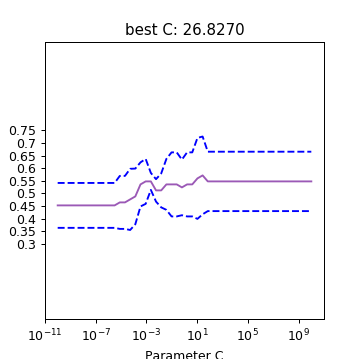

In [5437]:
test_with_rfe=False

figname = 'bestC%s' % '_fit_rfe' if test_with_rfe else 'bestC'

figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    
print(figname)

if test_with_rfe:
    dual = cX[:, kept_rids].shape[0] > cX[:, kept_rids].shape[1]
else:
    dual = cX.shape[0] > cX.shape[1]
    
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1) #, C=self.clfparams['C_val'])

if test_with_rfe:
    bestC = get_best_C(svc, StandardScaler().fit_transform(cX[:, kept_rids]), cy, output_dir=output_dir, figname=figname, close=False)
else:
    bestC = get_best_C(svc, StandardScaler().fit_transform(cX), cy, output_dir=output_dir, figname=figname, close=False)



##### RFE to find best features for decoding accuracy

(84, 248)
C: defaultC, 1.0
N features 26 26 (248,)


<IPython.core.display.Javascript object>


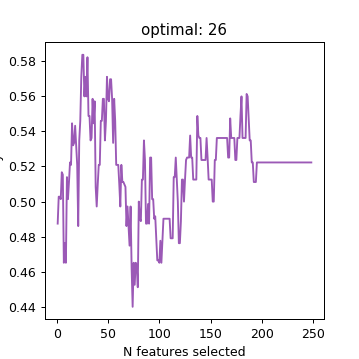

fitRFE_defaultC_trainAB_split0.30trials_across_size_20_40


In [5409]:
# Can find best features first (C=1, or biC or defaultC...), then go back and re-run bestC

bigC = 1e6
defaultC = 1.0

dual = cX.shape[0] > cX.shape[1]
print(cX.shape)
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=defaultC) #, C=self.clfparams['C_val'])

if svc.C == bigC:
    C_str = 'bigC'
elif svc.C == 1:
    C_str = 'defaultC'
else:
    C_str = 'bestC'
print("C: %s," % C_str, svc.C)

rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
fit = rfe.fit(StandardScaler().fit_transform(cX), cy)
#fit = rfe.fit(cX, cy)

best_score = fit.grid_scores_[fit.n_features_ - 1]
kept_rids = fit.get_support(indices=True)
nfeatures_best = len(kept_rids) #fit.n_features_
print("N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape)
all_scores = fit.grid_scores_


fig = pl.figure(figsize=(4,4))
pl.plot(range(1, len(all_scores) + 1), all_scores)
pl.xlabel("N features selected")
pl.ylabel(scoring)
pl.title("optimal: %i" % len(kept_rids))

figname = 'fitRFE_%s' % C_str
figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    
print(figname)
    
pl.savefig(os.path.join(output_dir, '%s.png' % figname))


#### Get subset of data based on hyperparameter tuning

In [5438]:
fit_best = True

if fit_best:
    roi_indices = kept_rids.copy()
else:
    roi_indices = np.arange(0, cX.shape[1])

xdata = StandardScaler().fit_transform(cX[:, roi_indices])
xlabels = cy
print(xdata.shape)

(84, 26)


In [5439]:
C = defaultC

print("C-val:", C)
dual = xdata.shape[0] > xdata.shape[1]
print("dual:", dual)
print(xdata.shape)
svc = LinearSVC(random_state=0, dual=dual, C=C) #multi_class='ovr') #, C=self.clfparams['C_val'])


C-val: 1.0
dual: True
(84, 26)


In [5440]:
print(len(kept_rids))
xdata_test = StandardScaler().fit_transform(test_cx[:, roi_indices])
xlabels_test = test_cy
    


26


In [5441]:
print(xdata.shape)
print(xdata_test.shape)

(84, 26)
(216, 26)


# Cross-validation

In [5442]:
print("N folds (CV): %i" % cv_nfolds)
cv_nfolds = 5
kfold = StratifiedKFold(n_splits=cv_nfolds, shuffle=True)
cv_results = cross_val_score(svc, xdata, xlabels, cv=kfold, scoring='accuracy')
print("CV RESULTS [%s]: %.3f (%.3f)" % (scoring, cv_results.mean(), cv_results.std()*2.)) # Print score and 95% CI of score estimate
print(cv_results)


N folds (CV): 5
CV RESULTS [accuracy]: 0.772 (0.240)
[ 0.88888889  0.72222222  0.625       0.6875      0.9375    ]


## Do permutation test for classif score

Classification score 0.680555555556 (pvalue : 0.003996003996)


<IPython.core.display.Javascript object>


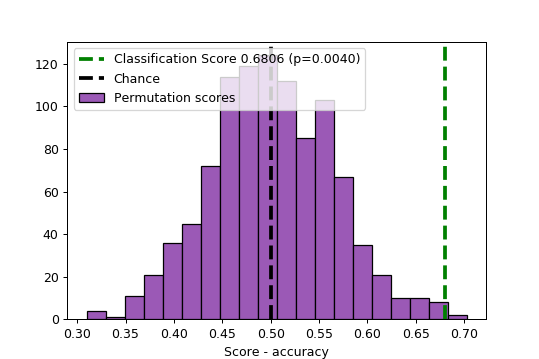

permutation_test_trainAB_split0.30trials_across_size_20_40


In [5443]:
permutation_test = True
n_permutations =  1000
n_jobs = 1

if permutation_test:
    # -----------------------------------------------------------------------------
    # How significant is our classification score(s)?
    # Calculate p-value as percentage of runs for which obtained score is greater 
    # than the initial classification score (i.e., repeat classification after
    # randomizing and permuting labels).
    # -----------------------------------------------------------------------------
    score, permutation_scores, permutation_pvalue = permutation_test_score(
                                            svc, xdata, xlabels,
                                            scoring=scoring, 
                                            cv=kfold, 
                                            n_permutations=n_permutations, 
                                            n_jobs=n_jobs)

    print("Classification score %s (pvalue : %s)" % (score, permutation_pvalue))


if permutation_test:
    
    # View histogram of permutation scores            
    fig = pl.figure(figsize=(6,4))
    n_classes = np.unique([cy]).size

    pl.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    ylim = pl.ylim()
    pl.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score %.4f (p=%.4f)' % (score, permutation_pvalue))
    pl.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance')
    pl.ylim(ylim)
    pl.legend()
    pl.xlabel('Score - %s' % scoring)

    figname = 'permutation_test'
    figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    


    pl.savefig(os.path.join(output_dir, '%s.png' % figname))
    print(figname)

###### Get confusion matrix

Getting cv folds for confusion matrix (labels: [0.0, 106.0])
Normalized confusion matrix


<IPython.core.display.Javascript object>


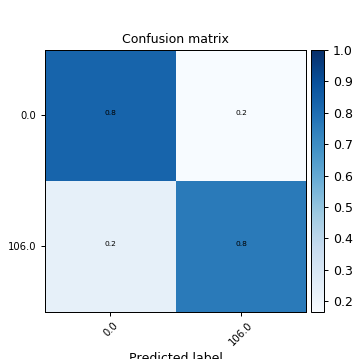

confusion_matrix_trainAB_split0.30trials_across_size_20_40


In [5444]:
print("Getting cv folds for confusion matrix (labels: %s)" % str(train_labels))

xlabels = np.array(xlabels)
loo = cross_validation.StratifiedKFold(xlabels, n_folds=cv_nfolds, shuffle=True)
predicted = []
true = []
cv_train_ixs = [] 
cv_test_ixs = []
for train, test in loo: #, groups=groups):
    #print train, test
    cv_train, cv_test = xdata[train,:], xdata[test,:]
    cv_train_labels, cv_test_labels = xlabels[train], xlabels[test]
    
    y_pred = svc.fit(cv_train, cv_train_labels).predict(cv_test)
    
    predicted.append(y_pred)
    true.append(cv_test_labels)
    cv_train_ixs.append(train)
    cv_test_ixs.append(test)



cmatrix = None
if not isinstance(predicted[0], (int, float, str)) and len(predicted[0]) > 1:
    cmatrix = confusion_matrix(true[0], predicted[0], labels=train_labels)
    for iter_idx in range(len(predicted))[1:]:
        #print "adding iter %i" % iter_idx
        cmatrix += confusion_matrix(true[iter_idx], predicted[iter_idx], labels=train_labels)
    conf_mat_str = 'AVG'
    
plot_confusion_matrix(cmatrix, train_labels, normalize=True)


figname = 'confusion_matrix'
figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    

pl.savefig(os.path.join(output_dir, '%s.png' % figname))

print(figname)

###### Look at CV accuracy by stimulus condition:

In [5445]:
config_sorter = 'size' # 'size' #'size' #'xpos' #'morphlevel' #'position'

if config_sorter is not None:
    sort_configs = list(set([d.conditions.loc[cfg][config_sorter] for cfg in trainlabels]))
    print(sort_configs)

print(trainlabels.shape)
print(xdata.shape)
print(xdata_test.shape)

[40.0, 20.0]
(84,)
(84, 26)
(216, 26)


In [5446]:
results_by_config = {}

# Sort CV results by config_sorter (even if trained class (i.e., 'class_name') is different):

for fold, (pred,tru,ixs) in enumerate(zip(predicted, true, cv_test_ixs)):
    corresp_configs = trainlabels[ixs] # True config labels of tested samples in current cv fold
    configs_tested = list(set(corresp_configs))
    
    for cfg in configs_tested:
        curr_sort_value = d.conditions.loc[cfg][config_sorter]
        if curr_sort_value not in results_by_config.keys():
            results_by_config[curr_sort_value] = {}
        if fold not in results_by_config[curr_sort_value].keys():
            results_by_config[curr_sort_value][fold] = []

        # Get index in curr fold for current config:
        fold_ixs = [i for i, c in enumerate(corresp_configs) if c==cfg]
        if train_transform_subset is False:
            assert all([t==curr_sort_value for t in tru[fold_ixs]])
        ncorrect = [1 if p==t else 0 for p, t in zip(pred[fold_ixs], tru[fold_ixs])]
        results_by_config[curr_sort_value][fold].extend(ncorrect)
        results_by_config[curr_sort_value][fold].extend(ncorrect)
        

# Get average score within config
average_scores_by_config = {}
sem_scores_by_config={}
std_scores_by_config={}

for sort_value in sort_configs:
    average_scores_by_config[sort_value] = np.mean([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])
    sem_scores_by_config[sort_value] = stats.sem([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])
    std_scores_by_config[sort_value] = np.std([np.mean(results_by_config[sort_value][k]) for k in range(cv_nfolds)])

average_scores_by_config


{20.0: 0.8056349206349207, 40.0: 0.79188311688311697}

<IPython.core.display.Javascript object>


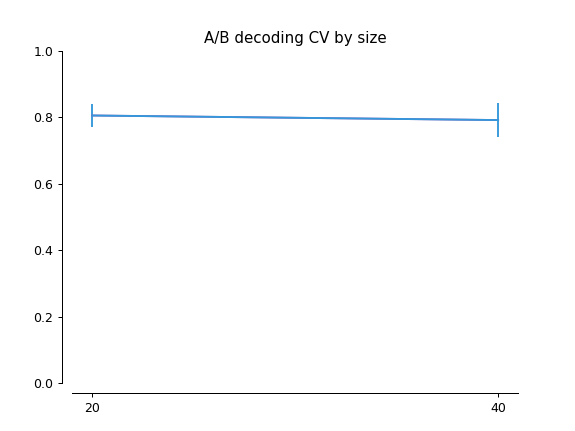

cv_accuracy_by_size_trainAB_split0.30trials_across_size_20_40


In [5447]:
# Plot CV accuracy by trained transform:

plot_sem = True


fig, ax = pl.subplots() #pl.figure()
x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]
if plot_sem:
    yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]
else:
    yerr = [v for k, v in sorted(std_scores_by_config.items(), key=lambda x: x[0])]


pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)

ax.set_xticks([k for k in sorted(average_scores_by_config.keys())])
ax.set_xticklabels([int(k) for k in sorted(average_scores_by_config.keys())])
ax.set_ylim([0, 1])
pl.title("A/B decoding CV by %s" % config_sorter)
sns.despine(offset=8)

figname = 'cv_accuracy_by_%s' % config_sorter
figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    

pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

In [5356]:
if config_sorter == 'position' or config_sorter == 'xpos':
    xvals = list(set([float(pos.split('_')[0]) for pos in positions]))
    if config_sorter == 'xpos':
        yvals = ypos
        print(yvals)
    else:
        yvals = list(set([float(pos.split('_')[1]) for pos in positions]))
    print("%i xvals, %i yvals" % (len(xvals), len(yvals)))
    nxpos = len(xvals)
    nypos = len(yvals)
    accuracy_grid = np.empty((nypos, nxpos))

    print(accuracy_grid)
else:
    accuracy_grid = None
    ypos_test = ypos
    xpos_test = xpos



if config_sorter == 'position' or config_sorter == 'xpos':

    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            if config_sorter == 'position':
                pos_str = '%.1f_%.1f' % (x, y)
            else:
                pos_str = x
            print(pos_str)
            if pos_str not in average_scores_by_config.keys():
                #print pos_str
                score = 0
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots(figsize=(8,4)) #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    # ax.set_xticks(np.arange(nxpos))
    # ax.set_xticklabels([str(i) for i in xpos])

    # ax.set_yticks(np.arange(nypos))
    # ax.set_yticklabels([str(i) for i in ypos])

    # pl.colorbar()
    pl.savefig(os.path.join(output_dir, 'CV_accuracy_decode_%s_by_%s_heatmap.png' % (class_name, config_sorter)))

#### Save CV results:

In [5448]:

results_fname = 'results_%s' % fov_dirname
results_fname = '%s%s%s' % (results_fname, train_test_cfg_str, train_subset_cfg_str)    

results_outfile = os.path.join(output_dir, '%s.pkl' % results_fname)
print("Saving: %s" % results_outfile)

cv_results = {'average_scores_by_config': average_scores_by_config,
             'sem_scores_by_config': sem_scores_by_config,
             'std_scores_by_config': std_scores_by_config,
             'cv_permutation_test': {'score': score, 
                                   'pvalue': permutation_pvalue,
                                   'n_permutations': n_permutations,
                                   'scoring': scoring,
                                   'cv_kfold': kfold},
             'train_sample_indices': train_indices,
             'split_train_test': split_train_test,
             'perc_held_test': perc_test}


model_params = {'C': svc.C,
               'svc': svc}


results = {'model': model_params,
           'cv_results': cv_results
          }

    
with open(results_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
#print(results_outfile)

Saving: /n/coxfs01/2p-data/JC067/LILL/20190319_FOV1_traces002/classifiers/decode_AB_train_test_size_subsets/results_20190319_FOV1_traces002_trainAB_split0.30trials_across_size_20_40.pkl


# Train and test classifier

In [5449]:
print(xdata.shape)
print(len(xlabels))

(84, 26)
84


In [5450]:
C = defaultC # bestC
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])
svc.fit(xdata, xlabels)


# Test samples:
predictions = svc.predict(xdata_test)
#print(xlabels_test)

print("xdata:", xdata.shape)
print("xdata_test:", xdata_test.shape)

xdata: (84, 26)
xdata_test: (216, 26)


In [5451]:
print("train labels:", train_labels)
print("test labels:", test_labels)

train labels: [0.0, 106.0]
test labels: [0.0, 106.0]


In [5452]:

#correct_choices = [1 if p==t else 0 for p, t in zip(predictions, xlabels_test)]
#print(np.mean(correct_choices))

test_scores_by_config = {}
for cfg in list(set(testlabels)):
    curr_value = d.conditions.loc[cfg][config_sorter]
    
    curr_indices = np.where(testlabels==cfg) # index into predictions and "class labeled" test_labels
    correct = [1 if p==t else 0 for p, t in zip(predictions[curr_indices], xlabels_test[curr_indices])]
    if curr_value not in test_scores_by_config.keys():
        test_scores_by_config[curr_value] = []
        
    test_scores_by_config[curr_value].extend(correct)


### Sort test scores
MORPHS:  Sort test scores by choice m0 or m100 | SIZE:  Sort test scores by tested size

In [5453]:

test_scores = {}
for tested_value in test_scores_by_config.keys():
    if test_morphs:
        curr_indices = np.where(xlabels_test==tested_value)[0]
        test_scores[tested_value] = predictions[curr_indices]
    else:
        test_scores[tested_value] = np.mean(test_scores_by_config[tested_value])

print(test_scores)
pchoose100 = {}; pchoose100_sem = {};
if test_morphs: # Also ave p choose 100:
    all_morph_levels = sorted(list(set(d.conditions['morphlevel'])))
    #print(all_morph_levels)
    #all_morph_levels = [0, 27, 53, 79, 106]

    for morph in all_morph_levels:
        if morph in train_labels and split_train_test is False:
            print("... using CV results for train sample:", morph)
            mean_cv = []
            for pred, tru in zip(predicted, true):
                curr_trials = np.where(tru==morph)[0]
                mean_cv.append(np.mean([1 if p==106 else 0 for p in pred[curr_trials]]))
            pchoose100[morph] = np.mean(mean_cv)
            pchoose100_sem[morph] = stats.sem(mean_cv)
        else:
            pchoose100[morph] = np.mean([1 if p==106 else 0 for p in test_scores[morph]])
            pchoose100_sem[morph] = stats.sem([1 if p==106 else 0 for p in test_scores[morph]])

#pchoose100
    
# choices = {}
# for test_value in test_scores_by_config.keys():
#     #print(test_value)
#     curr_indices = np.where(xlabels_test==test_value)[0]
#     choices[test_value] = predictions[curr_indices]

{40.0: 0.72222222222222221, 50.0: 0.48333333333333334, 20.0: 0.72222222222222221, 10.0: 0.51666666666666672, 30.0: 0.45000000000000001}


In [5454]:
pchoose100

{}

### Update test results to results file

In [5455]:

test_results = {'test_scores': test_scores,
                'test_scores_by_config': test_scores_by_config}

if test_morphs:
    test_results.update({'pchoose100': pchoose100,
                         'pchoose100_sem': pchoose100_sem,
                         'all_morph_levels': all_morph_levels})

    
if config_sorter == 'position' or config_sorter == 'xpos':
    test_results.update({
     'accuracy_grid' : accuracy_grid,
     'ypos_test': ypos_test,
     'xpos_test' : xpos_test
    })
    
results.update({'test_results': test_results})
    
with open(results_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
print("All results saved to: %s" % results_outfile)
print(results.keys())

All results saved to: /n/coxfs01/2p-data/JC067/LILL/20190319_FOV1_traces002/classifiers/decode_AB_train_test_size_subsets/results_20190319_FOV1_traces002_trainAB_split0.30trials_across_size_20_40.pkl
['model', 'cv_results', 'test_results']


# Visualize test results

### Morph decoding: morph test

In [5456]:
if test_morphs:
    # ---------------------------------------------------------------------------------
    # PLOT MORPH CURVE
    # ---------------------------------------------------------------------------------

    pl.figure()
    x = sorted(all_morph_levels)
    y = [v for k, v in sorted(pchoose100.items(), key=lambda x: x[0])]
    yerr = [v for k, v in sorted(pchoose100_sem.items(), key=lambda x: x[0])]
    print(yerr)
    pl.plot(x, y)
    pl.errorbar(x=x, y=y, yerr=yerr)
    pl.ylim([0, 1])
    sns.despine(offset=8, trim=True)

    figname = 'train_anchors_test_morphs_psychometric_%imorphs2_sp' % len(all_morph_levels)
    figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    

    pl.savefig(os.path.join(output_dir, '%s.png' % figname))

    print(figname)

In [5457]:
average_scores_by_config

{20.0: 0.8056349206349207, 40.0: 0.79188311688311697}

### Morph decoding: size test

chance: 0.5


<IPython.core.display.Javascript object>


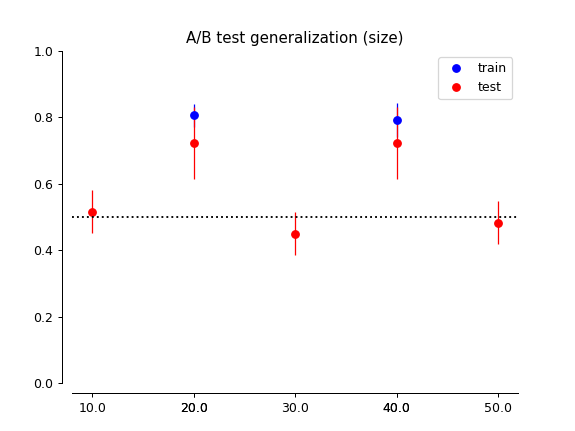

decode_morphlevel_by_size_linear_trainAB_split0.30trials_across_size_20_40


In [5458]:
chance_level = 1./len(train_labels)
print("chance:", chance_level)

plot_sem = True

fig, ax = pl.subplots() #pl.figure()

x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]

if plot_sem:
    yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]
else:
    yerr = [v for k, v in sorted(std_scores_by_config.items(), key=lambda x: x[0])]

ax.plot(x, y, marker='o', markerfacecolor='b', markeredgecolor='b', linestyle='None', label='train')
ax.errorbar(x=x, y=y, yerr=yerr, ecolor='b', elinewidth=1, linestyle='None')


test_x = sorted(test_scores_by_config.keys())
test_y = [np.mean(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]
if plot_sem:
    test_yerr = [stats.sem(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]
else:
    test_yerr = [np.std(vals) for k, vals in sorted(test_scores_by_config.items(), key=lambda x:x[0])]

ax.plot(test_x, test_y, marker='o', markerfacecolor='r', markeredgecolor='r', linestyle='None', label='test')
ax.errorbar(x=test_x, y=test_y, yerr=test_yerr, ecolor='r', elinewidth=1, linestyle='None')

pl.ylim([0, 1])
xtick_labels = copy.copy(x)
xtick_labels.extend(test_x)
ax.set_xticks(sorted(xtick_labels))
ax.set_xticklabels(sorted(xtick_labels))

pl.title("A/B test generalization (%s)" % config_sorter)
sns.despine(offset=8)
pl.legend()

chance_level = 1./len(train_labels)
ax.axhline(y=chance_level, color='k', linestyle=':')


figname = 'decode_%s_by_%s_linear' % (class_name, config_sorter)
figname = '%s%s%s' % (figname, train_test_cfg_str, train_subset_cfg_str)    

pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

# BREAK

#### Combine single-transform trained CV results:

In [1953]:

#classifier_regime = 'decode_ori_train_test_size_single'

curr_animal = animalid
V1_results_fpaths = glob.glob(os.path.join(D.rootdir, curr_animal, '%s' % visual_area, '*FOV*', 'classifiers', '%s' % classifier_regime, 'results_*.pkl'))
all_sessions = []
for vi, vpath in enumerate(V1_results_fpaths):
    fn = os.path.split(vpath)[-1]
    #print(vi, fn)
    dset_id = re.search('results_(.+?)_train', fn).group(1)
    all_sessions.append(dset_id)

unique_sessions = sorted(list(set(all_sessions)))
for si, session in enumerate(unique_sessions):
    print(si, session)
sel = raw_input("Select IDX of datasets to include (comma-sep): ")
session_list = sorted([unique_sessions[int(si)] for si in sel.split(',')])

print(session_list)

data_identifier = '|'.join([curr_animal, '|'.join(session_list)])
print(data_identifier)

0 20190322_FOV1_traces001_segmentedLM
Select IDX of datasets to include (comma-sep): 0
['20190322_FOV1_traces001_segmentedLM']
JC073|20190322_FOV1_traces001_segmentedLM


In [1954]:
tlevels  = dict((session, dict()) for session in session_list)
for si, session in enumerate(session_list):
    curr_fpaths = [f for f in V1_results_fpaths if session in f]
    curr_tlevels = {}
    for fi, fpath in enumerate(sorted(curr_fpaths)):
        fn = os.path.splitext(os.path.split(fpath)[-1])[0]
        curr_tlevels[fi] = int(fn.split('_%s_' % transform_spanned)[-1])
    
    print('Train/Test across: %s. Total %i levels.' % (transform_spanned, len(curr_tlevels.keys())))

    tlevels[session] = curr_tlevels

print(tlevels)

ntransform_levels = list(set([len(tlevels[s].keys()) for s in tlevels.keys()]))
assert len(ntransform_levels) == 1
ntransform_levels = ntransform_levels[0]


Train/Test across: size. Total 5 levels.
{'20190322_FOV1_traces001_segmentedLM': {0: 10, 1: 20, 2: 30, 3: 40, 4: 50}}


In [1955]:
cv_perm_thr = 0.05
cv_score_thr = 0.70

V1 = {'train': dict(), 'test': dict()}
                    
for t_level in np.arange(0, ntransform_levels):
    V1['train'][t_level] = []
    V1['test'][t_level] = dict()
    for session in tlevels.keys():
        t_value = tlevels[session][t_level]
        fpath = [f for f in V1_results_fpaths if session in f and '%s_%s' % (transform_spanned, str(t_value)) in f][0]

        with open(fpath, 'rb') as f: 
            res = pkl.load(f)

        if res['cv_results']['cv_permutation_test']['pvalue'] >= cv_perm_thr:
            continue
        if res['cv_results']['cv_permutation_test']['score'] < cv_score_thr:
            continue

        # Get training score
        V1['train'][t_level].append( res['cv_results']['average_scores_by_config'][t_value] )

        # Get testing score 
        #curr_test_results = {}
        for t_value, t_score in res['test_results']['test_choices'].items():
            level_key = [tl for tl, tv in tlevels[session].items() if tv==t_value][0]
            #curr_test_results[level_key] = t_score
            if level_key not in V1['test'][t_level].keys():
                V1['test'][t_level][level_key] = []
            V1['test'][t_level][level_key].append(t_score)
        
        
        #V1['test'][t_level][level_key].append(t_score)

In [1956]:
curr_test_results

{0: 0.41999999999999998,
 1: 0.56000000000000005,
 2: 0.68000000000000005,
 3: 0.80000000000000004}

In [1957]:
V1['test'][tlevel]

{0: [0.48333333333333334],
 1: [0.6166666666666667],
 2: [0.56666666666666665],
 3: [0.73333333333333328]}

In [1958]:
test_keys

[]

<IPython.core.display.Javascript object>


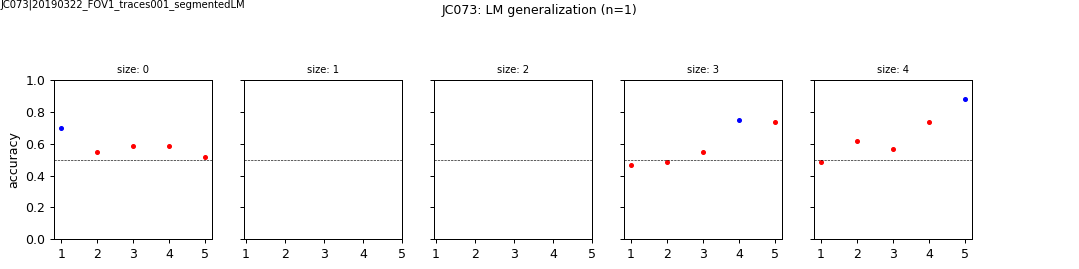

0 : [1, 2, 3, 4]
1 : []
2 : []
3 : [0, 1, 2, 4]
4 : [0, 1, 2, 3]
/n/coxfs01/2p-data/JC073/LM
/n/coxfs01/2p-data/JC073/LM/test_gen_train_single_size_20190322_FOV1_traces001_segmentedLM.png


In [1959]:
fig, axes = pl.subplots(1, ntransform_levels, figsize=(12,3), sharey=True) #pl.figure()

ai = 0
for tlevel, tscores in V1['train'].items():
    ax = axes[ai]
    ax.plot(tlevel, np.mean(V1['train'][tlevel]), 'b.', lw=0)
    ax.errorbar(x=tlevel, y=np.mean(V1['train'][tlevel]), yerr=stats.sem(V1['train'][tlevel]), color='b')
    
    #test_keys, test_vals, = sorted(V1['test'][tlevel].items(), key=lambda x: x[0])
    test_keys = sorted(V1['test'][tlevel].keys())
    test_vals = [np.mean(V1['test'][tlevel][tk]) for tk in test_keys]
    test_vals_sem = [stats.sem(V1['test'][tlevel][tk]) for tk in test_keys]
    print(tlevel, ":", test_keys)
    ax.plot(test_keys, test_vals, 'r.', lw=0)
    ax.errorbar(x=test_keys, y=test_vals, yerr=test_vals_sem, color='r', fmt='none')
    ax.set_ylim([0, 1])
    if ai == 0:
        ax.set_ylabel('accuracy')
    ax.axhline(y=chance_level, color='k', linestyle='--', lw=0.5)
    ax.set_xticks(np.arange(0, ntransform_levels))
    ax.set_xticklabels(np.arange(1, ntransform_levels+1))
    ax.set_title('%s: %i' % (transform_spanned, tlevel),  fontsize=8)
    ai += 1

pl.subplots_adjust(wspace=0.2, top=0.7, left=0.05)


label_figure(fig, data_identifier)

fig.suptitle('%s: %s generalization (n=%i)' % (animalid, visual_area, len(session_list)), fontsize=10)


figname = 'test_gen_train_single_%s_%s' % (transform_spanned, '_'.join(session_list))


visual_area_dir = os.path.join(D.rootdir, D.animalid, visual_area)
print(visual_area_dir)

pl.savefig(os.path.join(visual_area_dir, '%s.png' % figname))
print(os.path.join(visual_area_dir, '%s.png' % figname))


In [116]:

#classifier_regime = 'decode_ori_train_test_size_single'

V1_results = glob.glob(os.path.join(D.rootdir, 'JC*', 'V1', '*FOV*', 'classifiers', '%s' % classifier_regime, 'results_*.pkl'))
# for vi, vpath in enumerate(V1_results):
#     print(vi, os.path.split(vpath)[-1])
    
LI_results = glob.glob(os.path.join(D.rootdir, 'JC*', 'LI', '*FOV*', 'classifiers', '%s' % classifier_regime, 'results_*.pkl'))
# for vi, vpath in enumerate(LI_results):
#     print(vi, os.path.split(vpath)[-1])
    
V1_values = [int(os.path.splitext(vpath)[0].split('_sz')[-1]) for vpath in V1_results]
V1_values

LI_values = [int(os.path.splitext(vpath)[0].split('_sz')[-1]) for vpath in LI_results]
LI_values

V1 = {}
LI = {}
for vi, (val1, val2) in enumerate(zip(sorted(V1_values), sorted(LI_values))):
    fpath = [f for f in V1_results if 'sz%i' % val1 in f][0]
    with open(fpath, 'rb') as f: 
        res = pkl.load(f)
    V1[vi] = res
    
    fpath = [f for f in LI_results if 'sz%i' % val2 in f][0]
    with open(fpath, 'rb') as f: 
        res = pkl.load(f)
    LI[vi] = res
    

ValueError: invalid literal for int() with base 10: '/n/coxfs01/2p-data/JC059/V1/20190228_FOV1_traces001/classifiers/decode_AB_train_test_size/results_20190228_FOV1_traces001_train_size40_10_50'

In [114]:
CV = {'V1': {}, 'LI': {}}

for vi, val in enumerate(sorted(V1_values)):
    CV['V1'][val] = np.mean([av_score for classlabel, av_score in V1[vi]['average_scores_by_config'].items()])
for vi, val in enumerate(sorted(LI_values)):
    CV['LI'][val] = np.mean([av_score for classlabel, av_score in LI[vi]['average_scores_by_config'].items()])

In [115]:
CV

{'LI': {10: 0.34999999999999998,
  16: 0.52499999999999991,
  22: 0.51249999999999996,
  28: 0.52499999999999991,
  34: 0.66249999999999998},
 'V1': {10: 0.36249999999999999,
  15: 0.28749999999999998,
  20: 0.40000000000000002,
  25: 0.38749999999999996,
  30: 0.26250000000000001}}

In [128]:
# trained_transform = 'size'
# all_cfg_values = list(set(d.conditions['%s' % trained_transform]))
# print("%s:" % config_sorter, all_cfg_values)

# cv_results = [glob.glob(os.path.join(output_dir, 'results*_sz%i.pkl' % int(sz)))[0] for sz in all_cfg_values]

# cv_scores = {}
# for cval in all_cfg_values:
#     cv_result = glob.glob(os.path.join(output_dir, 'results*_sz%i.pkl' % int(cval)))[0]
#     with open(cv_result, 'rb') as f:
#         cvr = pkl.load(f)
#     cv_scores[cval] = cvr


In [129]:
output_dir

'/n/coxfs01/2p-data/JC073/LM/20190322_FOV1_traces001_segmentedLM/classifiers/decode_AB_train_anchors_test_morphs'

<IPython.core.display.Javascript object>


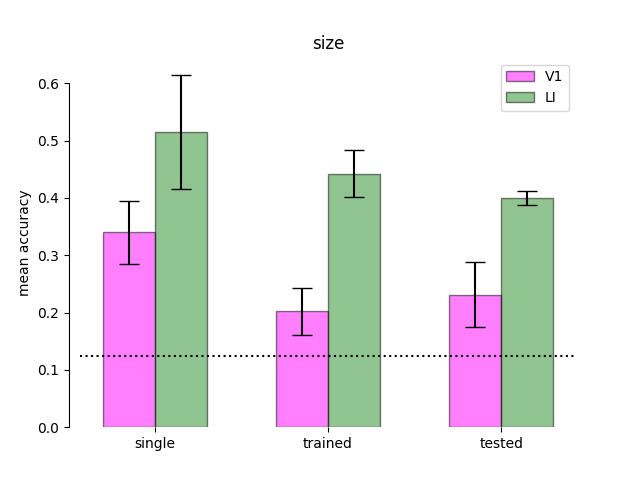

average_CV_by_size_singletrain2


In [2244]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(CV['V1'].values()), trained_scores['V1'], tested_scores['V1']]
 
# Choose the height of the cyan bars
bars2 = [np.mean(CV['LI'].values()), trained_scores['LI'], tested_scores['LI']]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(CV['V1'].values()), trained_std['V1'], tested_std['V1']]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(CV['LI'].values()), trained_std['LI'], tested_std['LI']]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['single', 'trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)


figname = 'average_CV_by_%s_singletrain2' % (trained_transform) #config_sorter
# if train_transform_subset:
#     figname = '%s_train_%s%s' % (figname, transform_spanned, '_'.join([str(int(i)) for i in train_transforms]))
# if len(xpos) > 0 or len(ypos) > 0 or len(size) > 0:
#     figname = '%s_x%s_y%s_sz%s' % (figname, '_'.join([str(int(x)) for x in xpos]), \
#                                   '_'.join([str(int(y)) for y in ypos]), '_'.join([str(int(s)) for s in size]))

pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

# Train classifier

In [94]:
# C = defaultC # bestC
# svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])
# svc.fit(xdata, xlabels)


# # Test samples:
# predictions = svc.predict(xdata_test)
# #print(xlabels_test)

# print("xdata:", xdata.shape)
# print("xdata_test:", xdata_test.shape)


# correct_choices = [1 if p==t else 0 for p, t in zip(predictions, xlabels_test)]
# print(np.mean(correct_choices))

# test_scores_by_config = {}
# for cfg in list(set(testlabels)):
#     curr_value = d.conditions.loc[cfg][config_sorter]
    
#     curr_indices = np.where(testlabels==cfg) # index into predictions and "class labeled" test_labels
#     correct = [1 if p==t else 0 for p, t in zip(predictions[curr_indices], xlabels_test[curr_indices])]
#     if curr_value not in test_scores_by_config.keys():
#         test_scores_by_config[curr_value] = []
        
#     test_scores_by_config[curr_value].extend(correct)


In [95]:
# test_scores = {}
# for tlabel in test_scores_by_config.keys():
#     test_scores[tlabel] = np.mean(test_scores_by_config[tlabel])

# print(test_scores)

{20.0: 0.48333333333333334, 30.0: 0.45000000000000001}


In [109]:
from matplotlib.patches import Rectangle

if config_sorter == 'position' or config_sorter=='xpos':
    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            if config_sorter == 'position':
                pos_str = '%.1f_%.1f' % (x, y)
            else:
                pos_str = x
            if pos_str not in average_scores_by_config.keys():
                #print pos_str
                score = test_scores[pos_str]
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots(figsize=(8,4)) #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    if config_sorter == 'position':
        ypos_test = list(set([float(pos.split('_')[1]) for pos in test_scores.keys()]))
        xpos_test = list(set([float(pos.split('_')[0]) for pos in test_scores.keys()]))

    test_box_x = [sorted(xvals).index(tx) for tx in xpos_test][0]
    test_box_y = [sorted(yvals).index(ty) for ty in ypos_test][0]
    ax.add_patch(Rectangle((test_box_x, test_box_y), len(xpos_test), len(ypos_test), fill=False, 
                           edgecolor='cornflowerblue', lw=3))
    pl.savefig(os.path.join(output_dir, 'decode_%s_by_%s_heatmap.png' % (class_name, config_sorter)))

In [110]:
chance_level = 1./len(train_labels)
print("chance:", chance_level)

chance: 0.5


#### PLOT

In [3007]:
results_V1 = glob.glob(os.path.join(D.rootdir, 'JC*', 'V1', '*FOV*', 'classifiers',\
                                    'decode_ori_train_test_size', 'results*.pkl'))
#print(results_V1)

results_LI = glob.glob(os.path.join(D.rootdir, 'JC*', 'LI*', '*FOV*', 'classifiers',\
                                    'decode_ori_train_test_size', 'results*.pkl'))
results_LI_tmp = [f for f in results_LI if 'JC026' not in f]

#add_jc026 = [f for f in results_LI if 'JC026' in f and '_x-14' in f][0]

results_LI = copy.copy(results_LI_tmp)
#results_LI.append(add_jc026)


#print(results_LI)

V1 = {'train_scores': [], 'test_scores': []}
LI = {'train_scores': [], 'test_scores': []}
for fpath in results_V1:
    with open(fpath, 'rb') as f:
        tmpV1 = pkl.load(f)
    V1['train_scores'].append(np.mean([v for k, v in tmpV1['average_scores_by_config'].items()]))
    V1['test_scores'].append(np.mean([v for k, v in tmpV1['test_scores_by_config'].items()]))
    V1['nvalues'] = len(tmpV1['average_scores_by_config'].keys())
    
for fpath in results_LI:
    with open(fpath, 'rb') as f:
        tmpLI = pkl.load(f)
    if 'test_scores_by_config' not in tmpLI.keys():
        print(fpath)
        continue
    LI['train_scores'].append(np.mean([v for k, v in tmpLI['average_scores_by_config'].items()]))
    LI['test_scores'].append(np.mean([v for k, v in tmpLI['test_scores_by_config'].items()]))
    LI['nvalues'] = len(tmpLI['average_scores_by_config'].keys())

    
# trained_scores = {'V1': np.mean([v for k, v in V1['average_scores_by_config'].items()]),
#                   'LI': np.mean([v for k, v in LI['average_scores_by_config'].items()])}
# trained_std = {'V1': np.std([v for k, v in V1['average_scores_by_config'].items()]),
#                'LI': np.std([v for k, v in LI['average_scores_by_config'].items()])}


# tested_scores = {'V1': np.mean([np.mean(v) for k, v in V1['test_scores_by_config'].items()]),
#                   'LI': np.mean([np.mean(v) for k, v in LI['test_scores_by_config'].items()])}
# tested_std = {'V1': np.std([np.mean(v) for k, v in V1['test_scores_by_config'].items()]),
#               'LI': np.std([np.mean(v) for k, v in LI['test_scores_by_config'].items()])}


In [3010]:
chance_level = 1/8.

<IPython.core.display.Javascript object>


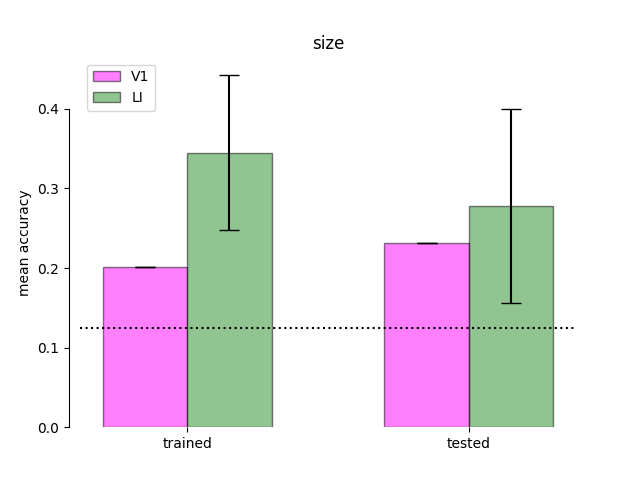

In [3011]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(V1['train_scores']), np.mean(V1['test_scores'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(LI['train_scores']), np.mean(LI['test_scores'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(V1['train_scores']), np.std(V1['test_scores'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(LI['train_scores']), np.std(LI['test_scores'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)

<IPython.core.display.Javascript object>


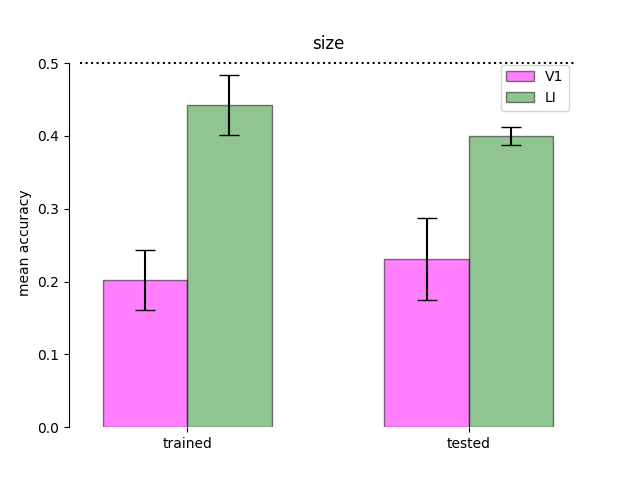

In [2775]:
# width of the bars
barw = 0.3
 
# Choose the height of the blue bars
bars1 = [trained_scores['V1'], tested_scores['V1']]
 
# Choose the height of the cyan bars
bars2 = [trained_scores['LI'], tested_scores['LI']]
 
# Choose the height of the error bars (bars1)
yer1 = [trained_std['V1'], tested_std['V1']]
 
# Choose the height of the error bars (bars2)
yer2 = [trained_std['LI'], tested_std['LI']]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barw for x in r1]
 
pl.figure()
# Create blue bars
pl.bar(r1, bars1, width = barw, color = 'magenta', yerr=yer1, label='V1',
      capsize=7, alpha=0.5, edgecolor='None')
 
# Create cyan bars
pl.bar(r2, bars2, width = barw, color='forestgreen', yerr=yer2, label='LI',
      capsize=7, alpha=0.5, edgecolor='None') 
 
# general layout
pl.xticks([r + barw*0.5 for r in range(len(bars1))], ['trained', 'tested'])
pl.ylabel('mean accuracy')
pl.legend()

pl.title('size')

pl.axhline(y=chance_level, color='k', linestyle=':')
# Show graphic
# pl.show()
sns.despine(trim=True, offset=8, bottom=True)

In [2917]:
LI

{'C': 0.00013257113655901109,
 'average_scores_by_config': {15.0: 0.26617647058823535,
  25.0: 0.24663484692122464,
  35.0: 0.22907647907647907},
 'roi_indices': array([ 1,  4,  5, 16, 28, 31, 36, 38, 39, 42, 44, 46, 51]),
 'sem_scores_by_config': {15.0: 0.070003707267128845,
  25.0: 0.01937863105554416,
  35.0: 0.057700330322896835},
 'std_scores_by_config': {15.0: 0.14000741453425772,
  25.0: 0.03875726211108832,
  35.0: 0.11540066064579368},
 'svc': LinearSVC(C=0.00013257113655901109, class_weight=None, dual=True,
      fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
      max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
      tol=0.0001, verbose=0),
 'test_transforms': [20, 30],
 'train_transforms': [25.0, 35.0, 15.0]}

<IPython.core.display.Javascript object>


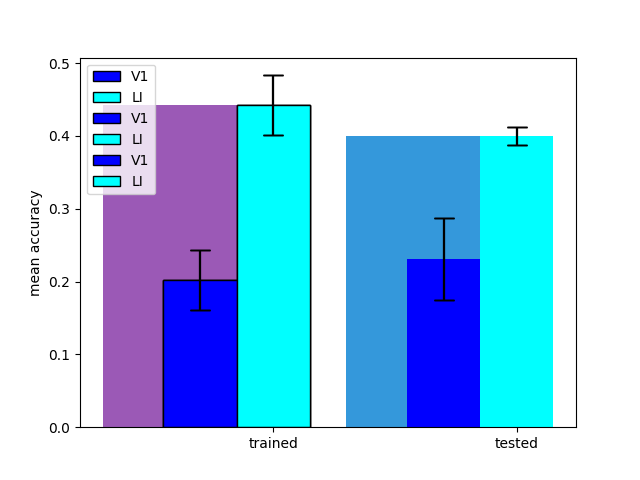

<Container object of 1 artists>

In [1153]:

trained_avg_score = np.mean([v for k, v in average_scores_by_config.items()])
trained_avg_score_std = np.std([v for k, v in average_scores_by_config.items()])

tested_avg_score = np.mean([np.mean(v) for k, v in test_scores_by_config.items()])
testd_avg_score_std = np.std([np.mean(v) for k, v in test_scores_by_config.items()])

fig, ax = pl.subplots()
pl.bar(0, trained_avg_score)
pl.bar(1, tested_avg_score)

# BREAK

# Plot average morph curves across sessions

In [5156]:
print(output_dir)


/n/coxfs01/2p-data/JC070/LILL/20190316_FOV1_traces001/classifiers/decode_AB_train_anchors_test_morphs


In [5157]:
visual_area_dir = os.path.join(D.rootdir, D.animalid, visual_area)
print(visual_area_dir)

results_files = glob.glob(os.path.join(visual_area_dir, '*FOV*', 'classifiers', '*train*_*morphs*', 'results_*.pkl'))

#results_files = [r for r in results_files if '20190320' in r]
for ri, rfile in enumerate(sorted(results_files)):
    print("%i: %s" % (ri, os.path.split(rfile)[-1]))
    

/n/coxfs01/2p-data/JC070/LILL
0: results_20190315_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz10.pkl
1: results_20190315_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz20.pkl
2: results_20190315_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz30.pkl
3: results_20190315_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz40.pkl
4: results_20190315_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz50.pkl
5: results_20190316_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz10.pkl
6: results_20190316_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz20.pkl
7: results_20190316_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz30.pkl
8: results_20190316_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz40.pkl
9: results_20190316_FOV1_traces001_trainAB_split0trials_configsubset_x_y_sz50.pkl


In [5158]:
# Load each session's results, get morph results, append to average across sessions

all_sessions = []
for f in results_files:
    curr_session = f.split('%s/' % visual_area)[1].split('_FOV')[0]
    curr_traceid = 'traces%s' % os.path.split(f)[-1].split('_traces')[-1].split('_')[0]
    all_sessions.append('%s_%s' % (curr_session, curr_traceid))

unique_sessions = sorted(list(set(all_sessions)), key=natural_keys)
for si, session in enumerate(unique_sessions):
    print(si, session)
sel = raw_input("Select IDX of sessions to include: ")
session_list = [unique_sessions[int(si)] for si in sel.split(',')]
print(session_list)

0 20190315_traces001
1 20190316_traces001
Select IDX of sessions to include: 0,1
['20190315_traces001', '20190316_traces001']


In [5159]:
cv_perm_thr = 0.05
cv_accuracy_thr = 0.70

In [5163]:
morph_results = dict((session, dict()) for session in session_list)
for si, session in enumerate(session_list):
    curr_session, curr_traceid = session.split('_')
    p100 = dict()
    p100_sem = dict()
    curr_fpaths = [f for f in results_files if curr_session in f and curr_traceid in f]
    for fp in curr_fpaths:
        with open(fp, 'rb') as f: 
            res = pkl.load(f)
        if res['cv_results']['cv_permutation_test']['pvalue'] >= cv_perm_thr:
            continue
        if res['cv_results']['cv_permutation_test']['score'] < cv_accuracy_thr:
            continue

        if curr_session == '20181018':
            print(res.keys())
        for mkey, prob in res['test_results']['pchoose100'].items():
            if mkey not in p100.keys():
                p100[mkey] = []
            p100[mkey].append(prob)
        
        nconds_passed = len(p100[mkey])
        morph_results[session]['nconds_passed'] = nconds_passed
        
    morph_results[session]['p100'] = p100
    morph_results[session]['p100_sem'] = p100_sem



In [5164]:
for si in morph_results.keys():
    print(si, sorted([int(mkey) for mkey in morph_results[si]['p100'].keys()]))


20190315_traces001 [0, 14, 27, 40, 53, 66, 79, 92, 106]
20190316_traces001 [0, 14, 27, 40, 53, 66, 79, 92, 106]


In [5165]:
print(visual_area_dir)

/n/coxfs01/2p-data/JC070/LILL


In [5166]:
session_list

['20190315_traces001', '20190316_traces001']

In [5167]:
nconds_passed = len(p100[mkey])

In [5168]:
colors = ['b', 'magenta', 'green', 'red', 'purple', 'orange']

<IPython.core.display.Javascript object>


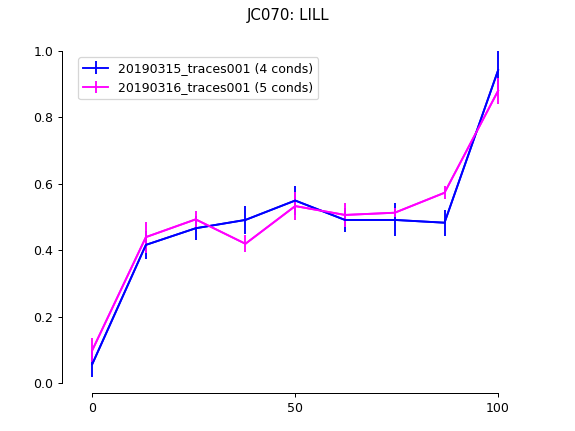

/n/coxfs01/2p-data/JC070/LILL/morphcurve_LILL_20190315_traces001_20190316_traces001.png


In [5169]:
fig, ax = pl.subplots()

for sidx, session in enumerate(morph_results.keys()):
    p100 = morph_results[session]['p100']
    p100_sem = morph_results[session]['p100_sem']

    mean_p100 = [(mkey, np.mean(vals)) for mkey, vals in p100.items()]
    sem_p100 = [(mkey, stats.sem(vals)) for mkey, vals in p100.items()]

    x = [v[0] for v in sorted(mean_p100, key=lambda x: x[0])]
    y = [v[1] for v in sorted(mean_p100, key=lambda x: x[0])]
    yerr = [v[1] for v in sorted(sem_p100, key=lambda x: x[0])]

    label = '%s (%i conds)' % (session, morph_results[session]['nconds_passed'])
    ax.plot(x, y, colors[sidx])
    ax.errorbar(x=x, y=y, yerr=yerr, color=colors[sidx], label=label)
    ax.set_ylim([0, 1])
    #ax.set_xticks(sorted([int(mkey) for mkey in p100.keys()]))
    ax.set_xticks([0, 53, 106])

    ax.set_xticklabels(['0', '50', '100'])
    sns.despine(offset=8, trim=True)
        
ax.legend(loc='upper left')
fig.suptitle('%s: %s' % (animalid, visual_area))

figname = 'morphcurve_%s_%s.png' % (visual_area, '_'.join(session_list))
pl.savefig(os.path.join(visual_area_dir, figname))
print(os.path.join(visual_area_dir, figname))

# pl.savefig(os.path.join(output_dir, figname))

<IPython.core.display.Javascript object>


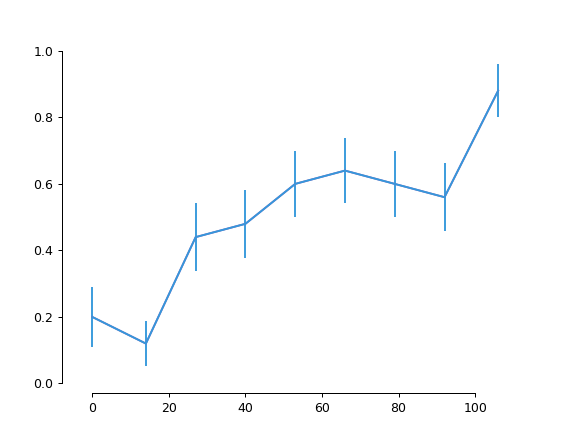

[0.089442719099991588, 0.066332495807107997, 0.10132456102380442, 0.10198039027185571, 0.10000000000000001, 0.097979589711327128, 0.10000000000000001, 0.10132456102380442, 0.080000000000000002]
train_anchors_test_morphs_psychometric_9morphs2.png
/n/coxfs01/2p-data/JC059/V1/20190227_FOV4_traces001/classifiers/decode_AB_train_anchors_test_morphs


In [377]:
pl.figure()
x = sorted(all_morph_levels)
y = [v for k, v in sorted(pchoose100.items(), key=lambda x: x[0])]
yerr = [v for k, v in sorted(pchoose100_sem.items(), key=lambda x: x[0])]
print(yerr)
pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)
pl.ylim([0, 1])
sns.despine(offset=8, trim=True)

figname = 'train_anchors_test_morphs_psychometric_%imorphs2' % len(all_morph_levels)
if len(xpos) > 0 or len(ypos) > 0:
    figname = '%s_x%s_y%s.png' % (figname, '_'.join([str(int(x)) for x in xpos]), '_'.join([str(int(y)) for y in ypos]))
else:
    figname = '%s.png' % figname
print(figname)
    
pl.savefig(os.path.join(output_dir, figname))

print(output_dir)

In [35]:
test_data = clf.train_results['test_data']
test_labels = clf.train_results['test_labels']
test_labels_config_names = clf.cy_labels[np.array(clf.train_results['test_labels'].index.tolist())]

In [37]:
test_results = clf.test_classifier(test_data=test_data, 
                                test_labels=test_labels, 
                                config_labels=test_labels_config_names, 
                                include_cv=False)
                
curr_output_dir = clf.classifier_dir

In [43]:
test_results.keys()

['test_labels',
 'results_by_class',
 'predicted_classes',
 'results_by_config',
 'test_data',
 'config_labels']

In [44]:
test_results['results_by_config']

{'config001': {'indices': array([  7,  47,  48,  78,  86, 119, 130]),
  'predicted': array([ 55.,  55.,  45.,  15.,  35.,  15.,  55.]),
  'true': 7       NaN
  47      NaN
  48     25.0
  78      NaN
  86      NaN
  119     NaN
  130     NaN
  dtype: float64},
 'config002': {'indices': array([ 72, 100, 142, 151]),
  'predicted': array([ 45.,  35.,  45.,  45.]),
  'true': 72      NaN
  100     NaN
  142    25.0
  151     NaN
  dtype: float64},
 'config003': {'indices': array([ 36, 122]),
  'predicted': array([ 15.,  15.]),
  'true': 36      NaN
  122    15.0
  dtype: float64},
 'config004': {'indices': array([ 16,  31, 103, 112]),
  'predicted': array([ 55.,  55.,  45.,  35.]),
  'true': 16      NaN
  31     35.0
  103    15.0
  112     NaN
  dtype: float64},
 'config005': {'indices': array([  4,  43,  45,  70, 152, 155]),
  'predicted': array([ 15.,  55.,  35.,  45.,  35.,  55.]),
  'true': 4     NaN
  43    NaN
  45    NaN
  70    NaN
  152   NaN
  155   NaN
  dtype: float64},
 'confi